In [25]:
import logging
from binance.futures import Futures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import json
import matplotlib.pyplot as plt
import os

In [45]:
#PARAMETERS
TIMEFRAME = "4h"
# PAIR = "BTCUSDT"
PAIR = "ENSUSDT"
DATA_WINDOW_LENGTH = 30
ROLLING_WINDOW_LENGTH = 6 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
LEVERAGE = 10

In [46]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [47]:
%%capture
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

In [48]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [49]:
df = process_klines(klines)
df;

In [50]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/2, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/2, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()

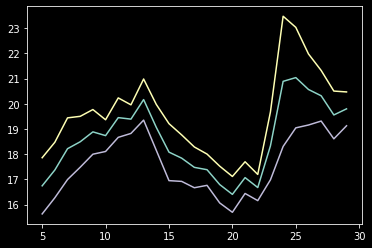

In [51]:
ax1 = plt.axis(); plt.plot(closes_mean)
ax2 = plt.axis(); plt.plot(closes_mean + closes_std)
ax3 = plt.axis(); plt.plot(closes_mean - closes_std)

In [52]:
avg_pdev = (closes_std/closes_mean).mean() # average percentual deviation from the EMA
print(avg_pdev)
callback_rate = round(avg_pdev, ndigits=2)
print(callback_rate)

0.05334480333547935
0.05


In [54]:
print(closes_std.mean())
print(closes_mean.mean())

1.0031596567494752
18.59082716032627


In [57]:
avg_pdev = (closes_std/closes_mean).mean()*100
avg_pdev

5.334480333547935

In [36]:
acc_info = futures_client.account();
acc_info["positions"];

In [37]:
def get_open_positions(acc_info):
    positions = acc_info["positions"]
    for position in positions:
        if float(position["positionAmt"]) != 0.0:
            print(f"{position['symbol']}: {position['unrealizedProfit']}; {position['positionAmt']}")
    

In [38]:
get_open_positions(acc_info)

ENSUSDT: -3.09037231; -25.7


In [23]:
response = futures_client.new_order(symbol=PAIR, side = "BUY", type= "TRAILING_STOP_MARKET", quantity= 25.7, reduceOnly = True, timeInForce="GTC", activationPrice= 19.650, callbackRate=0.1)

In [24]:
response

{'orderId': 821853577,
 'symbol': 'ENSUSDT',
 'status': 'NEW',
 'clientOrderId': 'zDnEQAHmNsyMBOFyO4deMi',
 'price': '0',
 'avgPrice': '0.0000',
 'origQty': '25.7',
 'executedQty': '0',
 'cumQty': '0',
 'activatePrice': '19.650',
 'priceRate': '0.1',
 'cumQuote': '0',
 'timeInForce': 'GTC',
 'type': 'TRAILING_STOP_MARKET',
 'reduceOnly': True,
 'closePosition': False,
 'side': 'BUY',
 'positionSide': 'BOTH',
 'stopPrice': '0',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'TRAILING_STOP_MARKET',
 'updateTime': 1651395952414}

In [20]:
# client = Client(key, secret, base_url="https://fapi.binance.com")

try:
    response = futures_client.new_order(symbol=PAIR, side = "BUY", type= "TRAILING_STOP_MARKET", quantity= 25.7, reduceOnly = True, timeInForce="GTC", activationPrice= 19.650)
    logging.info(response)
except ClientError as error:
    logging.error(
        "Found error. status: {}, error code: {}, error message: {}".format(
            error.status_code, error.error_code, error.error_message
        )
    )